In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.regularizers import l2

# Data Preprocessing
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

2025-02-06 21:02:19.327767: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-06 21:02:19.397276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-06 21:02:19.417982: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-06 21:02:19.424911: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-06 21:02:19.452505: I tensorflow/core/platform/cpu_feature_guar

In [3]:
training_set = train_datagen.flow_from_directory(
    'Teeth_Dataset/Training/',
    target_size=(256, 256),
    batch_size=32,
    shuffle=True,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    'Teeth_Dataset/Testing',
    target_size=(256, 256),
    batch_size=32,
    shuffle=False,
    class_mode='categorical'
)

validation_set = test_datagen.flow_from_directory(
    'Teeth_Dataset/Validation/',
    target_size=(256, 256),
    batch_size=32,
    shuffle=False,
    class_mode='categorical'
)


Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [4]:
# Print class names
print("Training Set Class Names:")
print(training_set.class_indices)

print("Test Set Class Names:")
print(test_set.class_indices)

print("Test Set Class Names:")
print(validation_set.class_indices)

Training Set Class Names:
{'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}
Test Set Class Names:
{'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}
Test Set Class Names:
{'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}


In [5]:
labels = {value: key for key, value in training_set.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : CaS
1 : CoS
2 : Gum
3 : MC
4 : OC
5 : OLP
6 : OT


# Display images before and after augmentation.

Found 3087 images belonging to 7 classes.


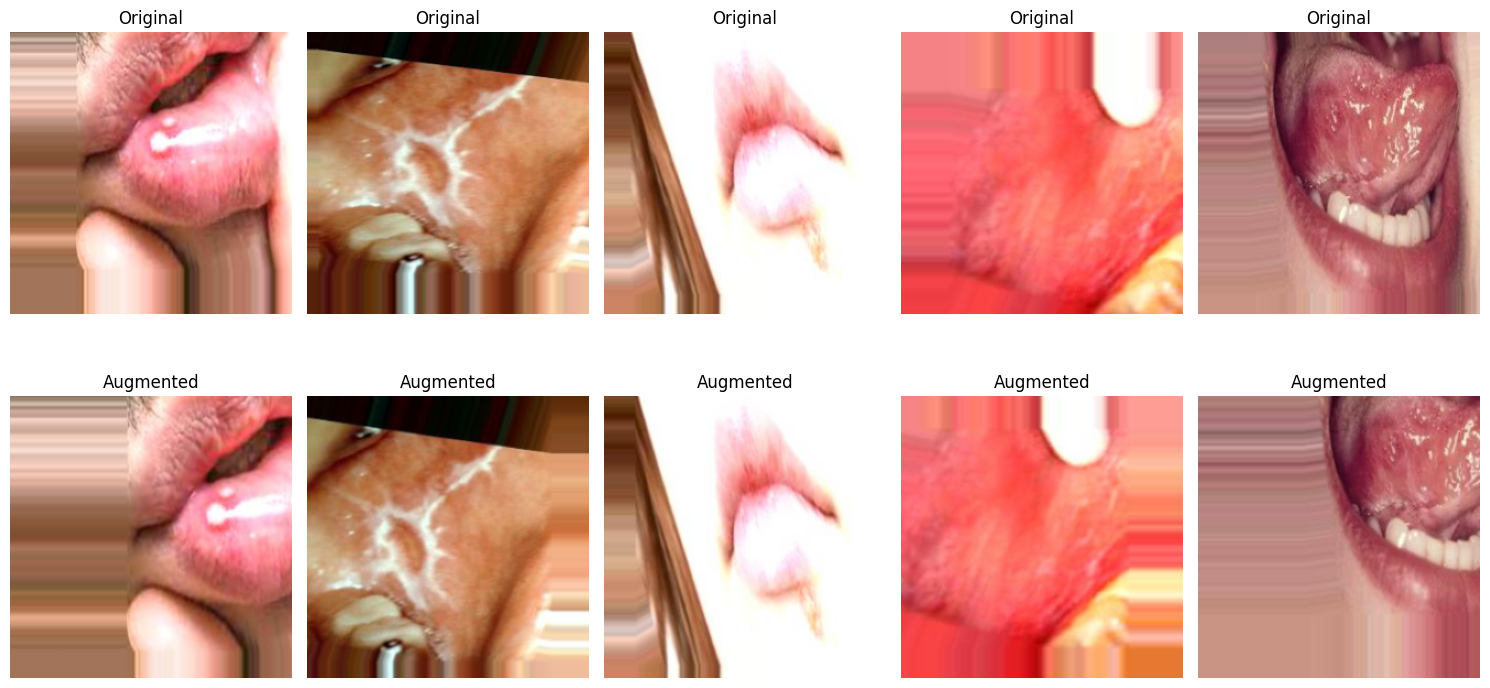

In [6]:
# Create a generator for original images (without augmentation)
original_datagen = ImageDataGenerator(rescale=1./255)
original_generator = original_datagen.flow_from_directory(
    'Teeth_Dataset/Training/',
    target_size=(256, 256),
    batch_size=32,
    shuffle=False,  # Maintain order for comparison
    class_mode='categorical'
)

# Get a batch of original images
sample_images, sample_labels = next(training_set)

# Generate augmented versions of the same images
augmented_images = []
for img in sample_images:
    augmented_img = train_datagen.random_transform(img)  # Apply augmentation
    augmented_images.append(augmented_img)
augmented_images = np.array(augmented_images)

# Display original and augmented images
plt.figure(figsize=(15, 8))
num_images = 5  # Number of image pairs to display

for i in range(num_images):
    # Original Image
    plt.subplot(2, num_images, i + 1)
    plt.imshow(sample_images[i])
    plt.title('Original')
    plt.axis('off')
    
    # Augmented Image
    plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(augmented_images[i])
    plt.title('Augmented')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, 5, padding='valid', activation='relu', input_shape=[256, 256, 3]),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='valid', kernel_regularizer=l2(0.00005)),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='valid', kernel_regularizer=l2(0.00005)),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(7, activation='softmax')
])

/home/font/LearnDL/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1738868551.791711   21973 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1738868552.375670   21973 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1738868552.375720   21973 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1738868552.378468   21973 cuda_exec

# CNN architecture

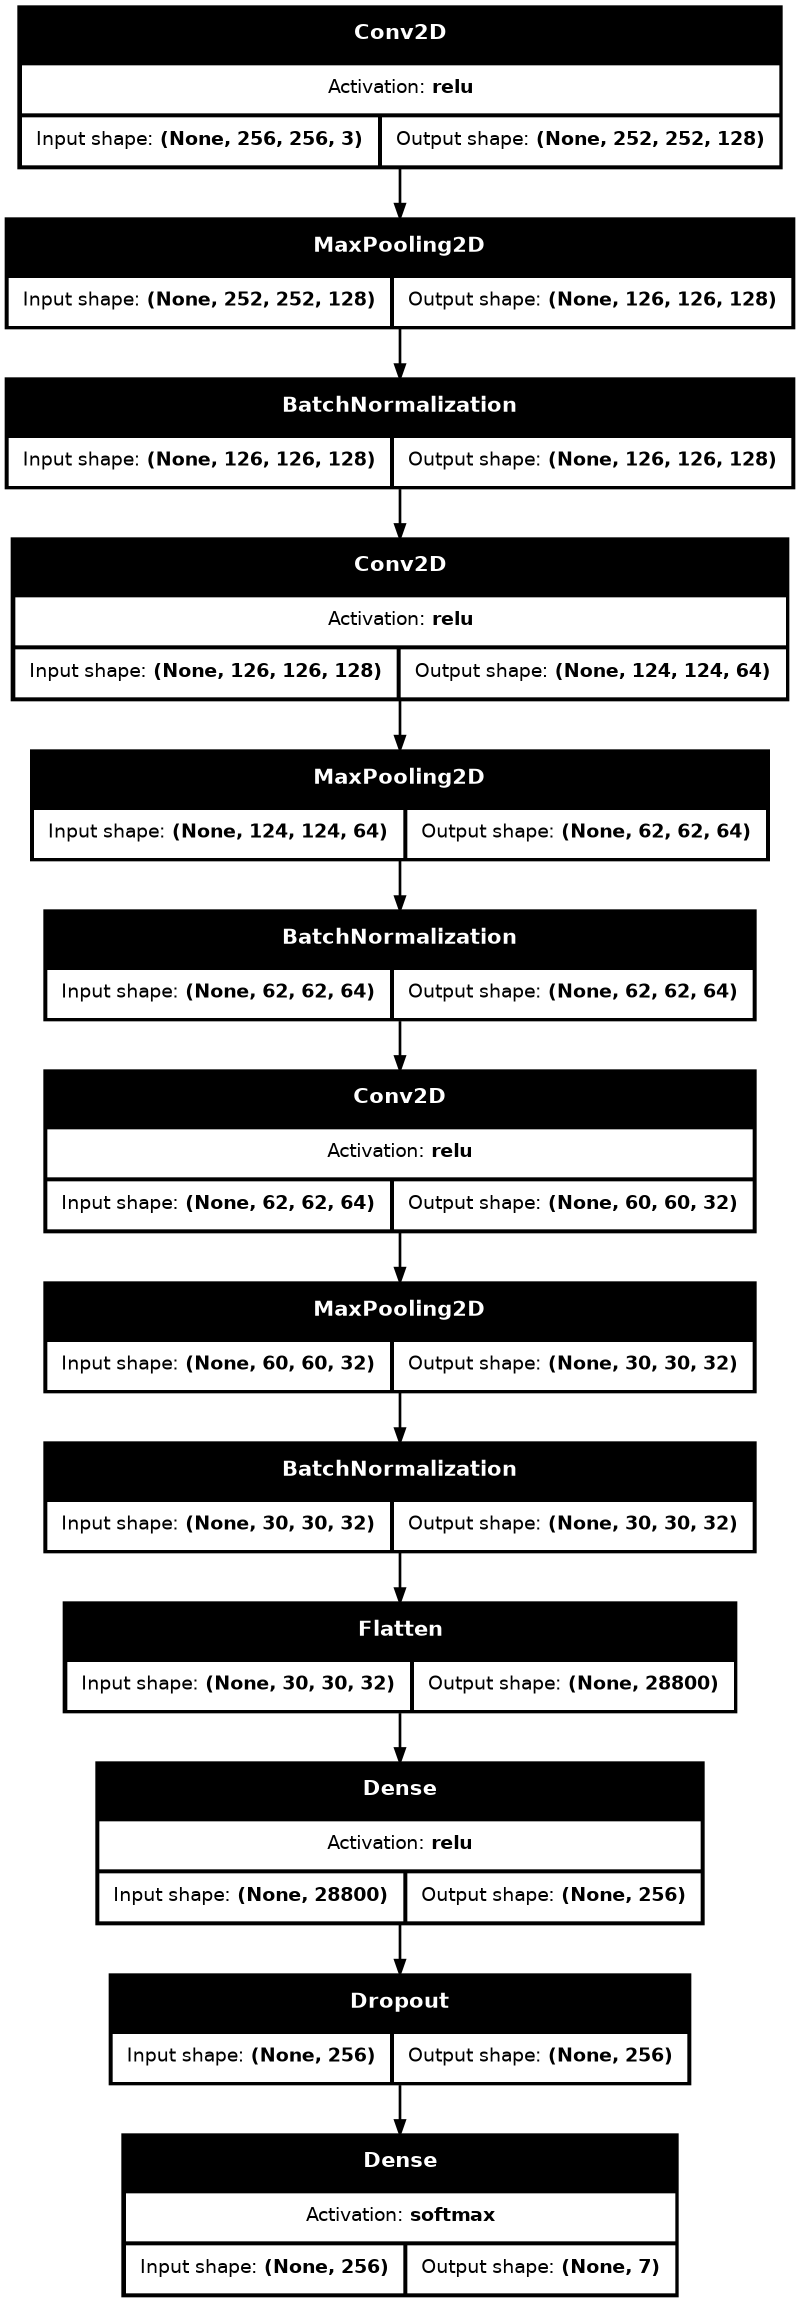

In [8]:
tf.keras.utils.plot_model(
    cnn,
    show_shapes = True,
    show_layer_activations = True,
    dpi=96
)

In [20]:
optimizer = Adam(learning_rate=0.001)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor (usually validation loss)
    factor=0.1,          # Factor by which to reduce the learning rate
    patience=10,         # Number of epochs with no improvement before reducing
    min_lr=0.00001       # Minimum learning rate
)

In [21]:
# Compile the model
cnn.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [22]:
# Train the model
history = cnn.fit(
    training_set,
    validation_data=validation_set,
    verbose=2,
    callbacks=[reduce_lr],
    epochs=150
)

Epoch 1/150


/home/font/LearnDL/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1738865167.443937    3930 service.cc:146] XLA service 0x7f1528014750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738865167.443984    3930 service.cc:154]   StreamExecutor device (0): Compute Capability 8.9
2025-02-06 20:06:08.419210: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-06 20:06:09.852135: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1738865181.819336    3930

97/97 - 44s - 452ms/step - accuracy: 0.2381 - loss: 12.7092 - val_accuracy: 0.2160 - val_loss: 8.5355 - learning_rate: 0.0010
Epoch 2/150
97/97 - 16s - 166ms/step - accuracy: 0.2864 - loss: 6.6555 - val_accuracy: 0.2451 - val_loss: 4.4984 - learning_rate: 0.0010
Epoch 3/150
97/97 - 16s - 164ms/step - accuracy: 0.3006 - loss: 3.0826 - val_accuracy: 0.2617 - val_loss: 3.7833 - learning_rate: 0.0010
Epoch 4/150
97/97 - 16s - 167ms/step - accuracy: 0.3437 - loss: 2.0634 - val_accuracy: 0.2189 - val_loss: 3.2908 - learning_rate: 0.0010
Epoch 5/150
97/97 - 16s - 166ms/step - accuracy: 0.3524 - loss: 1.8087 - val_accuracy: 0.2967 - val_loss: 3.1449 - learning_rate: 0.0010
Epoch 6/150
97/97 - 16s - 166ms/step - accuracy: 0.4007 - loss: 1.6415 - val_accuracy: 0.3920 - val_loss: 1.7041 - learning_rate: 0.0010
Epoch 7/150
97/97 - 16s - 167ms/step - accuracy: 0.4133 - loss: 1.5817 - val_accuracy: 0.4183 - val_loss: 1.5699 - learning_rate: 0.0010
Epoch 8/150
97/97 - 16s - 168ms/step - accuracy: 0.4

In [23]:
loss, accuracy = cnn.evaluate(test_set, batch_size=32)
print(f'accuracy = {accuracy}, loss= {loss}')

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9615 - loss: 0.1314
accuracy = 0.9581711888313293, loss= 0.14484958350658417


In [24]:
predictions = cnn.predict(test_set)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [25]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_set.classes
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

         CaS       0.97      0.96      0.97       160
         CoS       0.99      0.99      0.99       149
         Gum       0.97      0.97      0.97       120
          MC       0.93      0.96      0.94       180
          OC       0.92      0.94      0.93       108
         OLP       0.95      0.92      0.94       180
          OT       0.98      0.98      0.98       131

    accuracy                           0.96      1028
   macro avg       0.96      0.96      0.96      1028
weighted avg       0.96      0.96      0.96      1028



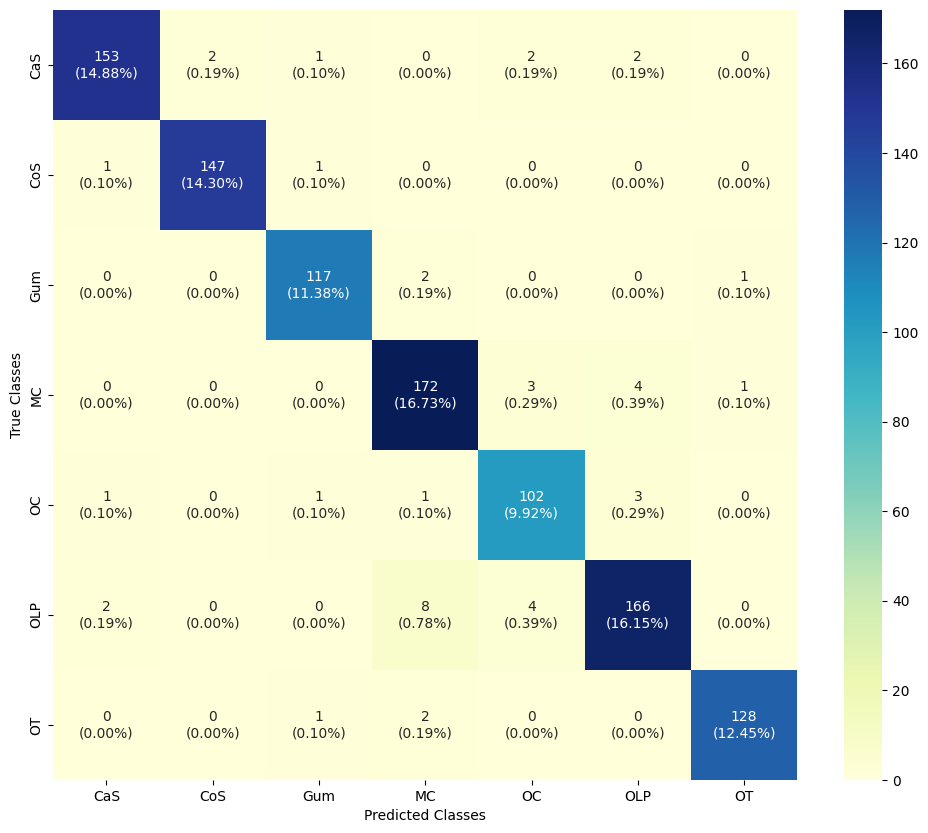

In [26]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(7, 7)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

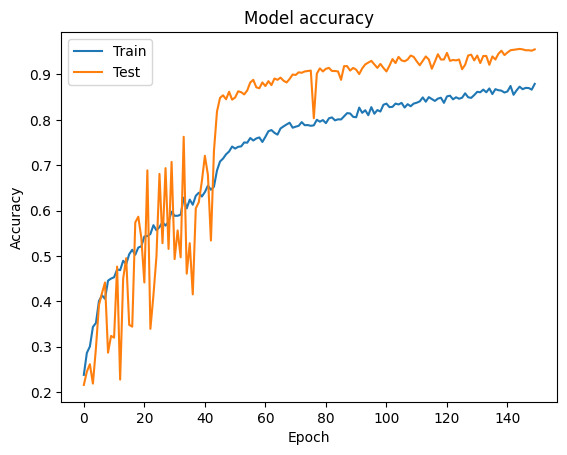

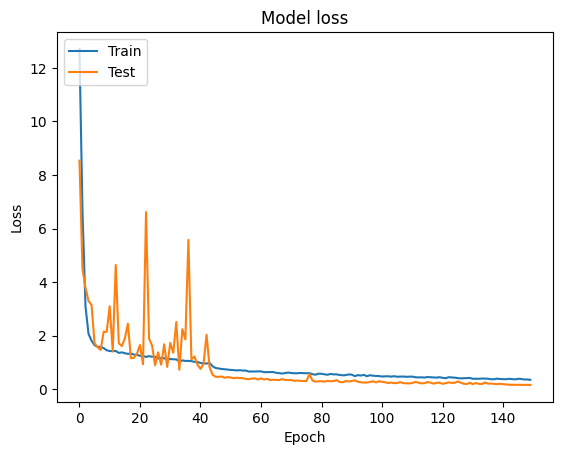

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [28]:
predictions = cnn.predict(training_set)
#predictions = cnn.predict(test_set)
predicted_classes = np.argmax(predictions, axis=-1)

true_classes_index = test_set.classes

code_int = {0 : 'CaS', 1 : 'CoS', 2 : 'Gum', 3 : 'MC', 4 : 'OC', 5 : 'OLP', 6 : 'OT'}

num_images = len(test_set.filenames)
num_images = len(test_set.filenames)

97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 180ms/step


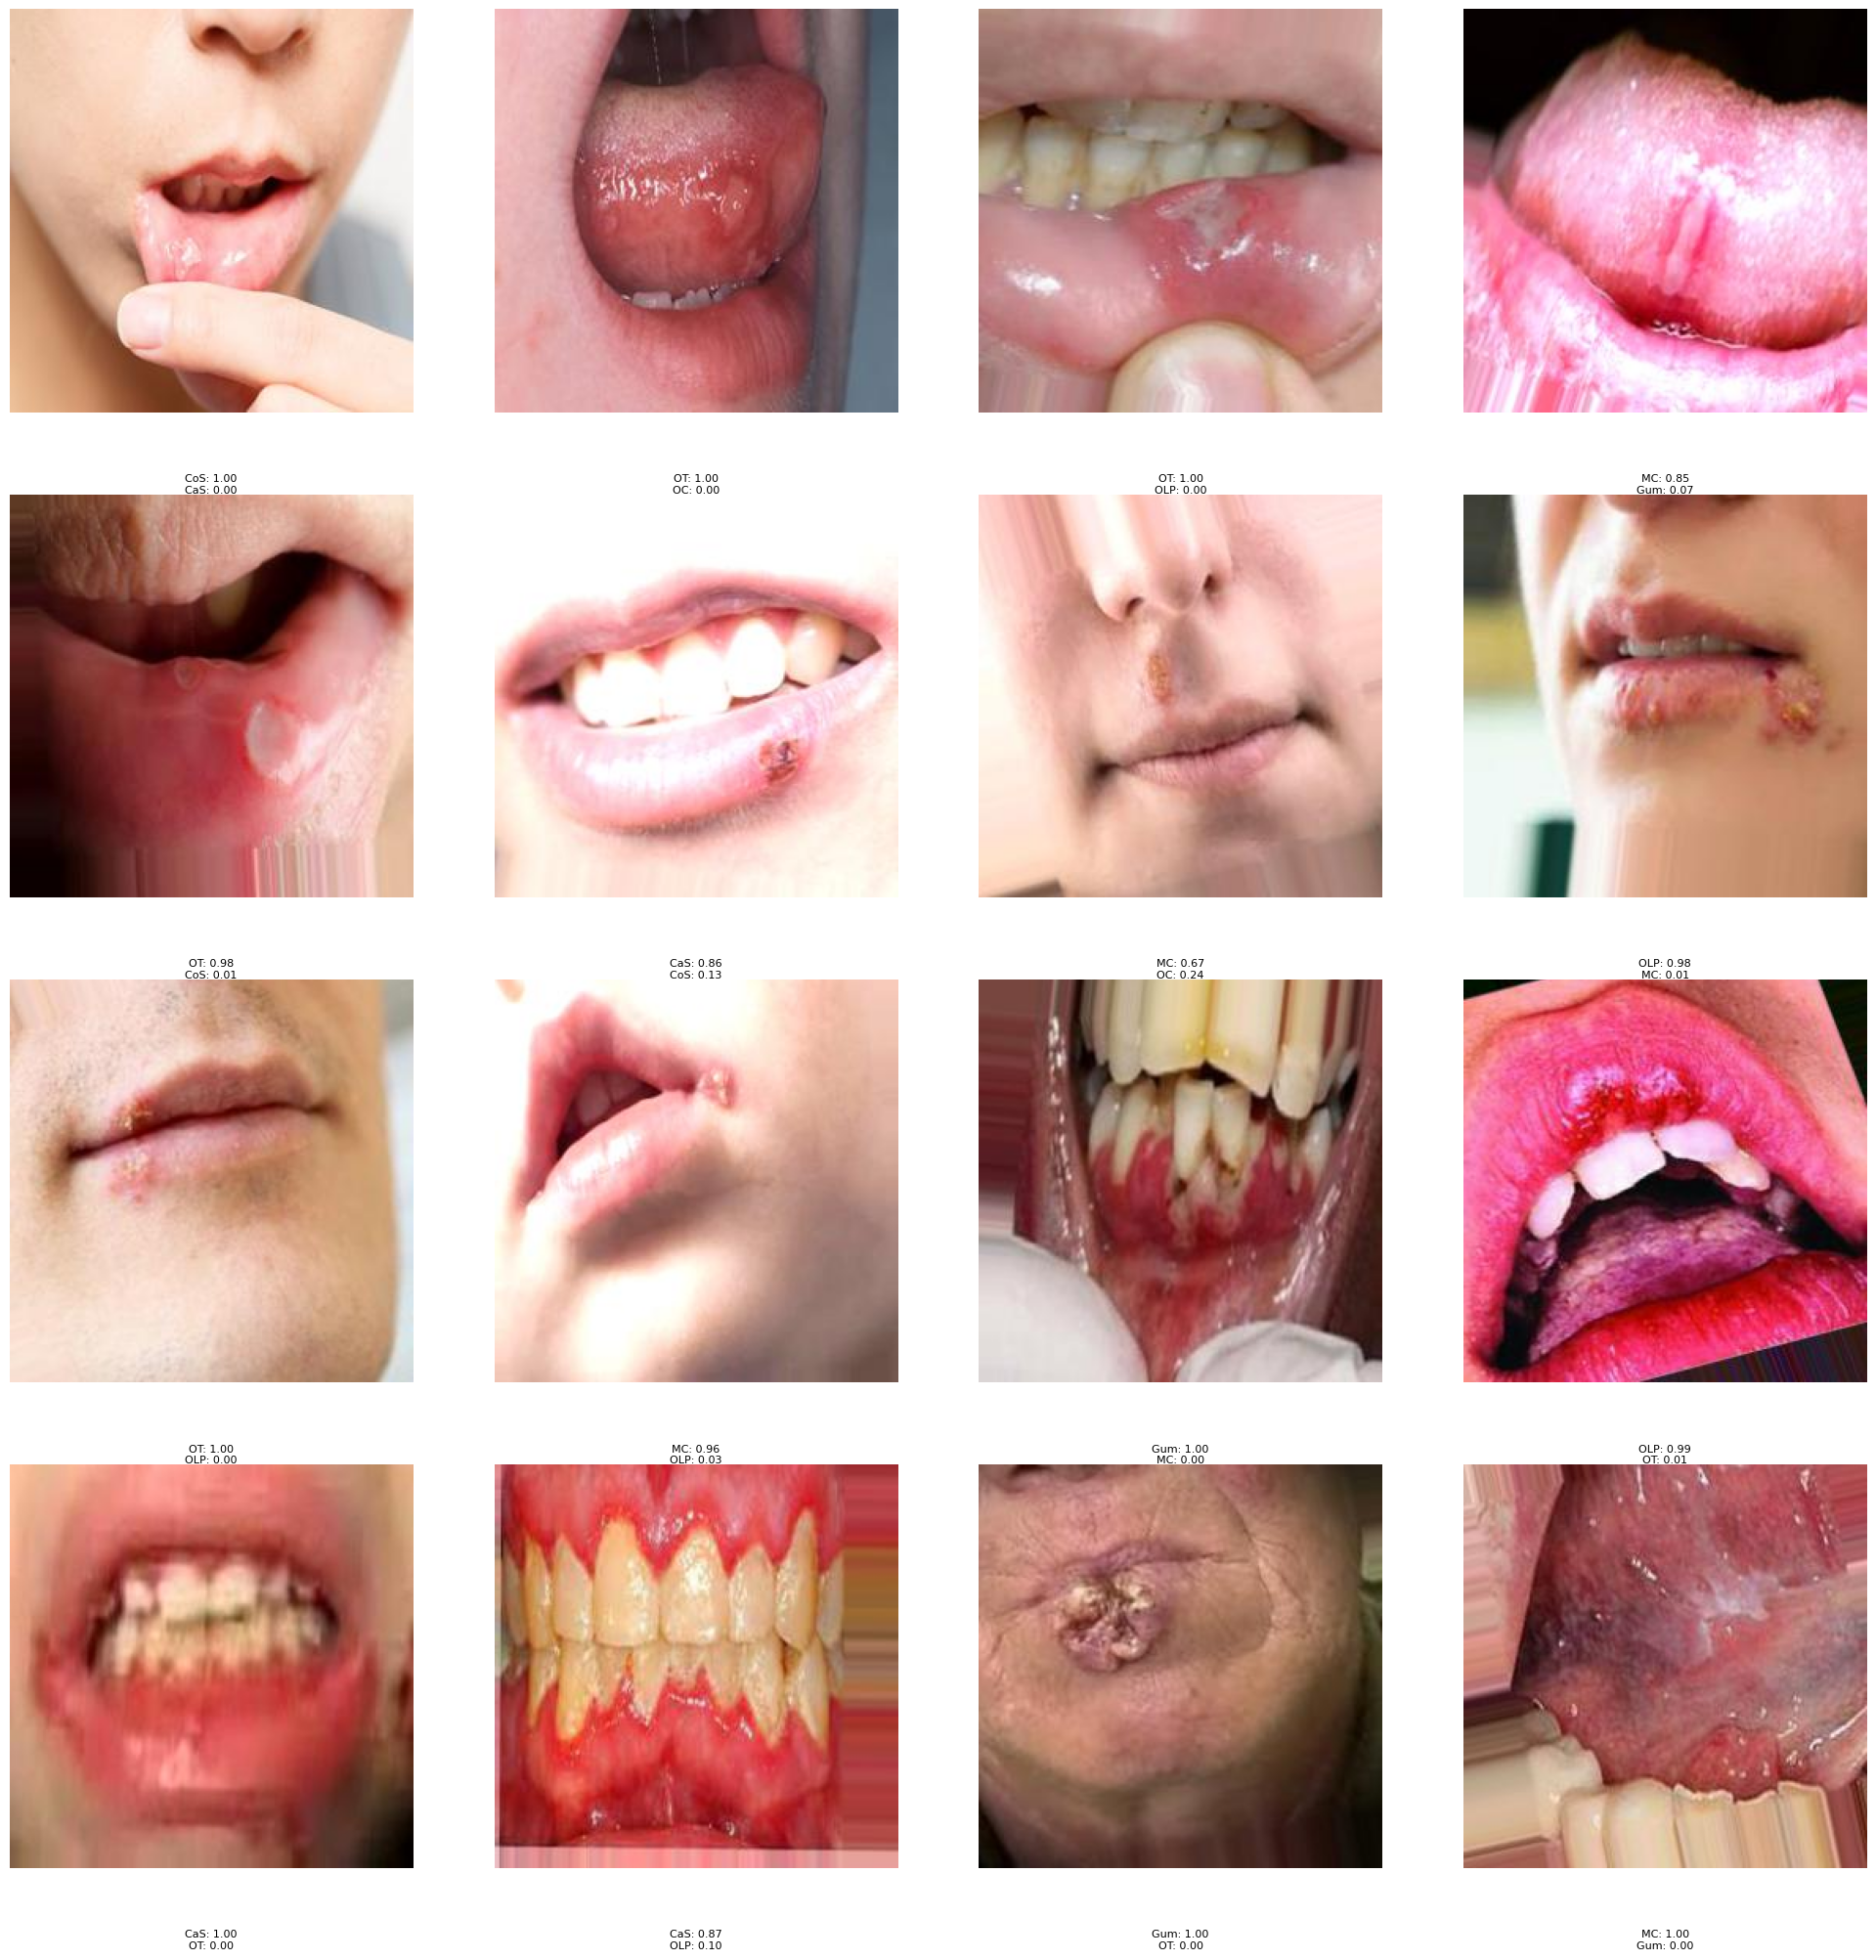

In [29]:

def get_top_n_predictions(predictions, n=2):
    top_n_indices = np.argsort(predictions)[-n:][::-1]
    return [(code_int[i], predictions[i]) for i in top_n_indices]

# Display images with their predicted classes and probabilities
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), tight_layout=True)  # Increased figure size
for i, ax in enumerate(axs.flat):
    if i >= num_images:
        break

    img = test_set[i][0]  # Get the i-th image
    img = img[0] if img.ndim == 4 else img
    # Remove batch dimension if present
    img = img.squeeze() if img.ndim == 4 else img
    
    ax.imshow(img, cmap=None)  # Use cmap=None for RGB images
    ax.axis('off')
    
    # Get top 3 predictions
    top_predictions = get_top_n_predictions(predictions[i])
    
    # Create a string with top 3 predictions and their probabilities
    pred_string = "\n".join([f"{class_name}: {prob:.2f}" for class_name, prob in top_predictions])
    
    # Add text below the image
    ax.text(0.5, -0.2, pred_string, size=8, ha="center", transform=ax.transAxes)

plt.show()

In [30]:
# Display images with their predicted classes
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), tight_layout=True)  # Adjust nrows and ncols as needed
for i, ax in enumerate(axs.flat):
    if i >= num_images:
        break

    img = test_set[i][0]  # Get the i-th image
    img = img[0] if img.ndim == 4 else img
    # Remove batch dimension if present
    img = img.squeeze() if img.ndim == 4 else img
    
    ax.imshow(img, cmap=None)  # Use cmap=None for RGB images
    ax.set_title(f'Actual: {code_int[true_classes_index[i]]} vs Predicted: {code_int[predicted_classes[i]]}')
    ax.axis('off')

plt.show()

In [31]:
# Save the model
cnn.save('cnn_teeths.keras')